## ML project 2

### Notes

- train model for each expert
- 0.5 'missing gender' somehing else than male/ female
- model ohne metadata wie age gender etc, just the coughs
- person coughs --> want to tell wether wet or dry
- dont use other expert information

Features:

- Columns C-BQ: Computed features in the time and frequency domain
- Column BR: The expert that reviwed the cough
- Columns BS-BV: Metadata features provided by users
    - Some values were not provided by users and were set to average values for each feature
- The 'SNR' feature exists for non-segmented coughs but not segmented coughs

In [32]:
import pandas as pd
import numpy as np
import IPython.display
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve, auc, roc_curve

from imblearn.over_sampling import SMOTE

from sklearn import svm
from sklearn.model_selection import StratifiedKFold

from src.utils.preprocessing import import_data, standardize

In [7]:
DATA_PATH = '../../data'

## Load Data

In [24]:
# Load data
# Labels: # 1 - Wet Cough # 0 - Dry Cough

coarse_data, coarse_labels = import_data(DATA_PATH, segmentation_type = 'coarse', is_user_features=True)
fine_data, fine_labels = import_data(DATA_PATH, segmentation_type = 'fine', is_user_features=True)
no_data, no_labels = import_data(DATA_PATH, segmentation_type = 'no', is_user_features=True)

display(coarse_data.head(2), fine_data.head(2), no_data.head(2))
#display(coarse_labels.head(2), fine_labels.head(2), no_labels.head(2))

EEPD50_100  EEPD100_150  \
subject                              file_id                            
008ba489-31ad-44d8-856b-fcf72369dc46 0               8.0          8.0   
                                     1               2.0          3.0   

                                              EEPD150_200  EEPD200_250  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0                7.0          6.0   
                                     1                2.0          3.0   

                                              EEPD250_300  EEPD300_350  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0                7.0          9.0   
                                     1                2.0          2.0   

                                              EEPD350_400  EEPD400_450  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0                7.0          7.0   
                                     1                3.0          3.0   

                                              EEPD450_500  EEPD500_550  ...  \
subject                              file_id                            ...   
008ba489-31ad-44d8-856b-fcf72369dc46 0                7.0          8.0  ...   
                                     1                3.0          3.0  ...   

                                              PSD_225-425  PSD_450-550  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0           0.314239     0.027049   
                                     1           0.093550     0.107780   

                                              PSD_1325-1600  PSD_1600-2000  \
subject                              file_id                                 
008ba489-31ad-44d8-856b-fcf72369dc46 0             0.015518       0.030041   
                                     1             0.013997       0.008304   

                                              PSD_2500-2900  PSD_3100-3700  \
subject                              file_id                                 
008ba489-31ad-44d8-856b-fcf72369dc46 0             0.047090       0.009558   
                                     1             0.045378       0.007341   

                                               Age  Gender  Resp_Condition  \
subject                              file_id                                 
008ba489-31ad-44d8-856b-fcf72369dc46 0        28.0     1.0             0.0   
                                     1        28.0     1.0             0.0   

                                              Symptoms  
subject                              file_id            
008ba489-31ad-44d8-856b-fcf72369dc46 0             0.0  
                                     1             0.0  

[2 rows x 70 columns]

EEPD50_100  EEPD100_150  \
subject                              file_id                            
008ba489-31ad-44d8-856b-fcf72369dc46 0               6.0          6.0   
                                     1               3.0          3.0   

                                              EEPD150_200  EEPD200_250  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0                5.0          4.0   
                                     1                3.0          4.0   

                                              EEPD250_300  EEPD300_350  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0                5.0          5.0   
                                     1                4.0          5.0   

                                              EEPD350_400  EEPD400_450  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0                6.0          6.0   
                                     1                4.0          4.0   

                                              EEPD450_500  EEPD500_550  ...  \
subject                              file_id                            ...   
008ba489-31ad-44d8-856b-fcf72369dc46 0                5.0          6.0  ...   
                                     1                4.0          3.0  ...   

                                              PSD_225-425  PSD_450-550  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0           0.398299     0.026407   
                                     1           0.230052     0.086242   

                                              PSD_1325-1600  PSD_1600-1900  \
subject                              file_id                                 
008ba489-31ad-44d8-856b-fcf72369dc46 0             0.013356       0.033366   
                                     1             0.023806       0.008824   

                                              PSD_2500-2900  PSD_3100-3700  \
subject                              file_id                                 
008ba489-31ad-44d8-856b-fcf72369dc46 0             0.043195       0.010385   
                                     1             0.056102       0.011429   

                                               Age  Gender  Resp_Condition  \
subject                              file_id                                 
008ba489-31ad-44d8-856b-fcf72369dc46 0        28.0     1.0             0.0   
                                     1        28.0     1.0             0.0   

                                              Symptoms  
subject                              file_id            
008ba489-31ad-44d8-856b-fcf72369dc46 0             0.0  
                                     1             0.0  

[2 rows x 70 columns]

,File_Name,EEPD50_100,EEPD100_150,EEPD150_200,EEPD200_250,EEPD250_300,EEPD300_350,EEPD350_400,EEPD400_450,EEPD450_500,...,PSD_225-425,PSD_450-550,PSD_1325-1600,PSD_1600-2000,PSD_2500-2900,PSD_3100-3700,Age,Gender,Resp_Condition,Symptoms
0,008ba489-31ad-44d8-856b-fcf72369dc46,72.0,73.0,71.0,70.0,69.0,71.0,70.0,72.0,71.0,...,0.274024,0.072153,0.017824,0.024982,0.041253,0.008166,28.0,1.0,0.0,0.0
1,008c1c9e-aeef-40c5-846c-24f1b964f884,86.0,87.0,86.0,83.0,82.0,80.0,82.0,79.0,74.0,...,0.102350,0.054859,0.037391,0.036934,0.032164,0.044875,44.0,0.0,0.0,0.0


1. Data Preprocessing

3.Deal with missing metadata appropriately

2.Perform exploratory data analysis and feature engineering (ex. examine theeffects of normalizing features, recursive feature elimination)

4
2.Make sure that data from a single subject does not end up in both thetraining and validation groups


### Normalisation

In [28]:
fine_data

EEPD50_100  EEPD100_150  \
subject                              file_id                            
008ba489-31ad-44d8-856b-fcf72369dc46 0               6.0          6.0   
                                     1               3.0          3.0   
                                     2               4.0          4.0   
                                     3               4.0          4.0   
                                     4               4.0          4.0   
...                                                  ...          ...   
ff8bfcc9-3df2-4752-8280-63f023fba31c 1               5.0          5.0   
ffa718e8-da65-4602-8da8-cda7cdc568f2 0               4.0          4.0   
                                     1               4.0          4.0   
                                     2               3.0          2.0   
                                     3               4.0          5.0   

                                              EEPD150_200  EEPD200_250  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0                5.0          4.0   
                                     1                3.0          4.0   
                                     2                3.0          4.0   
                                     3                4.0          4.0   
                                     4                5.0          4.0   
...                                                   ...          ...   
ff8bfcc9-3df2-4752-8280-63f023fba31c 1                6.0          6.0   
ffa718e8-da65-4602-8da8-cda7cdc568f2 0                4.0          3.0   
                                     1                3.0          3.0   
                                     2                2.0          2.0   
                                     3                5.0          5.0   

                                              EEPD250_300  EEPD300_350  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0                5.0          5.0   
                                     1                4.0          5.0   
                                     2                3.0          3.0   
                                     3                4.0          5.0   
                                     4                4.0          5.0   
...                                                   ...          ...   
ff8bfcc9-3df2-4752-8280-63f023fba31c 1                5.0          5.0   
ffa718e8-da65-4602-8da8-cda7cdc568f2 0                2.0          3.0   
                                     1                3.0          4.0   
                                     2                3.0          4.0   
                                     3                5.0          5.0   

                                              EEPD350_400  EEPD400_450  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0                6.0          6.0   
                                     1                4.0          4.0   
                                     2                4.0          4.0   
                                     3                3.0          4.0   
                                     4                3.0          4.0   
...                                                   ...          ...   
ff8bfcc9-3df2-4752-8280-63f023fba31c 1                5.0          5.0   
ffa718e8-da65-4602-8da8-cda7cdc568f2 0                3.0          3.0   
                                     1                4.0          4.0   
                                     2                3.0          4.0   
                                     3                5.0          4.0   

                                              EEPD450_500  EEPD500_550  ...  \
subject                              file_id                            ...   
008ba489-31ad-44d8-856b-fcf72369dc46 0           

In [33]:
X_coarse = standardize(coarse_data, 0,-3)
X_fine = standardize(fine_data, 0,-3)
X_no = standardize(no_data, 1,-3)

TypeError: standardize() takes 1 positional argument but 3 were given

### Data Preprocessing

### Find interesting features

In [156]:
no_data.columns

Index(['File_Name', 'EEPD50_100', 'EEPD100_150', 'EEPD150_200', 'EEPD200_250',
       'EEPD250_300', 'EEPD300_350', 'EEPD350_400', 'EEPD400_450',
       'EEPD450_500', 'EEPD500_550', 'EEPD550_600', 'EEPD600_650',
       'EEPD650_700', 'EEPD700_750', 'EEPD750_800', 'EEPD800_850',
       'EEPD850_900', 'EEPD900_950', 'EEPD950_1000', 'Zero_Crossing_Rate',
       'RMS_Power', 'Dominant_Freq', 'Spectral_Centroid', 'Spectral_Rolloff',
       'Spectral_Spread', 'Spectral_Skewness', 'Spectral_Kurtosis',
       'Spectral_Bandwidth', 'Spectral_Flatness', 'Spectral_StDev',
       'Spectral_Slope', 'Spectral_Decrease', 'MFCC_mean0', 'MFCC_mean1',
       'MFCC_mean2', 'MFCC_mean3', 'MFCC_mean4', 'MFCC_mean5', 'MFCC_mean6',
       'MFCC_mean7', 'MFCC_mean8', 'MFCC_mean9', 'MFCC_mean10', 'MFCC_mean11',
       'MFCC_mean12', 'MFCC_std0', 'MFCC_std1', 'MFCC_std2', 'MFCC_std3',
       'MFCC_std4', 'MFCC_std5', 'MFCC_std6', 'MFCC_std7', 'MFCC_std8',
       'MFCC_std9', 'MFCC_std10', 'MFCC_std11', 'MFCC_s

In [ ]:
#no_data_X_tr.iloc[:,0:-5]
# possibly nice features:
# 
# 
        
c0 = ['EEPD50_100', 'EEPD100_150', 'EEPD150_200', 'EEPD200_250', 'EEPD250_300', 'EEPD300_350', 'EEPD350_400', 'EEPD400_450',
       'EEPD450_500', 'EEPD500_550', 'EEPD550_600', 'EEPD600_650','EEPD650_700', 'EEPD700_750', 'EEPD750_800', 'EEPD800_850',
       'EEPD850_900', 'EEPD900_950', 'EEPD950_1000', 'Cough_Length']


c1 = ['Zero_Crossing_Rate',
       'RMS_Power', 'Dominant_Freq', 'Spectral_Centroid', 'Spectral_Rolloff',
       'Spectral_Spread', 'Spectral_Skewness', 'Spectral_Kurtosis',
       'Spectral_Bandwidth', 'Spectral_Flatness', 'Spectral_StDev',
       'Spectral_Slope', 'Spectral_Decrease']

c2 = ['MFCC_mean0', 'MFCC_mean1',
       'MFCC_mean2', 'MFCC_mean3', 'MFCC_mean4', 'MFCC_mean5', 'MFCC_mean6',
       'MFCC_mean7', 'MFCC_mean8', 'MFCC_mean9', 'MFCC_mean10', 'MFCC_mean11',
       'MFCC_mean12', 'MFCC_std0', 'MFCC_std1', 'MFCC_std2', 'MFCC_std3',
       'MFCC_std4', 'MFCC_std5', 'MFCC_std6', 'MFCC_std7', 'MFCC_std8',
       'MFCC_std9', 'MFCC_std10', 'MFCC_std11', 'MFCC_std12']

c3 = ['Crest_Factor',
       'Cough_Length', 'SNR']


c4 = ['Zero_Crossing_Rate',
       'RMS_Power', 'Dominant_Freq', 'Spectral_Centroid', 'Spectral_Rolloff',
       'Spectral_Spread', 'Spectral_Skewness', 'Spectral_Kurtosis',
       'Spectral_Bandwidth', 'Spectral_Flatness', 'Spectral_StDev',
       'Spectral_Slope', 'Spectral_Decrease', 'Crest_Factor',
       'Cough_Length', 'SNR', 'PSD_225-425', 'PSD_450-550', 'PSD_1325-1600',
       'PSD_1600-2000', 'PSD_2500-2900', 'PSD_3100-3700' ]

c5 = ['PSD_225-425', 'PSD_450-550', 'PSD_1325-1600',
       'PSD_1600-2000', 'PSD_2500-2900', 'PSD_3100-3700']

c6 = c3 + c5 # best one for Linear Regression

c7 = ['Expert', 'Age',
       'Gender', 'Resp_Condition', 'Symptoms'] # metadata

# best without 

# best columns
c = ['File_Name', 'Crest_Factor', 'Cough_Length', 'SNR', 'Expert', 'Age', 'Gender', 'Resp_Condition', 'Symptoms']
cc = ['File_Name', 'Crest_Factor', 'Cough_Length', 'Expert', 'Age', 'Gender', 'Resp_Condition', 'Symptoms']

### Inspect class imbalance

In [ ]:
print(no_labels['Label'].sum() / no_labels['Label'].shape[0], coarse_labels['Label'].sum() / coarse_labels['Label'].shape[0],
      fine_labels['Label'].sum() / fine_labels['Label'].shape[0])

In [ ]:
# Do something about it: SMODE
oversample = SMOTE(random_state=42)
fn_oversampled, ln_oversampled = oversample.fit_resample(fn, ln)

fn_oversampled = pd.DataFrame(fn_oversampled, columns=fn.columns)
ln_oversampled = pd.DataFrame(ln_oversampled, columns=ln.columns)

sns.countplot(x = 'Label', data=ln_oversampled)
print('Resampled dataset shape %s' % Counter(ln_oversampled["Label"]))

### Inspect Missing Data

### Dummy code categorical features

In [25]:
pd.get_dummies(X_fine, columns = ['Gender', 'Resp_Condition', 'Symptoms'])

EEPD50_100  EEPD100_150  \
subject                              file_id                            
008ba489-31ad-44d8-856b-fcf72369dc46 0          1.288931     1.291955   
                                     1         -1.057187    -1.072768   
                                     2         -0.275147    -0.284527   
                                     3         -0.275147    -0.284527   
                                     4         -0.275147    -0.284527   
...                                                  ...          ...   
ff8bfcc9-3df2-4752-8280-63f023fba31c 1          0.506892     0.503714   
ffa718e8-da65-4602-8da8-cda7cdc568f2 0         -0.275147    -0.284527   
                                     1         -0.275147    -0.284527   
                                     2         -1.057187    -1.861008   
                                     3         -0.275147     0.503714   

                                              EEPD150_200  EEPD200_250  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0           0.460313    -0.370510   
                                     1          -1.106628    -0.370510   
                                     2          -1.106628    -0.370510   
                                     3          -0.323158    -0.370510   
                                     4           0.460313    -0.370510   
...                                                   ...          ...   
ff8bfcc9-3df2-4752-8280-63f023fba31c 1           1.243783     1.192947   
ffa718e8-da65-4602-8da8-cda7cdc568f2 0          -0.323158    -1.152238   
                                     1          -1.106628    -1.152238   
                                     2          -1.890098    -1.933966   
                                     3           0.460313     0.411219   

                                              EEPD250_300  EEPD300_350  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0           0.380761     0.371252   
                                     1          -0.386563     0.371252   
                                     2          -1.153887    -1.181317   
                                     3          -0.386563     0.371252   
                                     4          -0.386563     0.371252   
...                                                   ...          ...   
ff8bfcc9-3df2-4752-8280-63f023fba31c 1           0.380761     0.371252   
ffa718e8-da65-4602-8da8-cda7cdc568f2 0          -1.921211    -1.181317   
                                     1          -1.153887    -0.405032   
                                     2          -1.153887    -0.405032   
                                     3           0.380761     0.371252   

                                              EEPD350_400  EEPD400_450  \
subject                              file_id                             
008ba489-31ad-44d8-856b-fcf72369dc46 0           1.089875     1.047051   
                                     1          -0.417561    -0.441848   
                                     2          -0.417561    -0.441848   
                                     3          -1.171280    -0.441848   
                                     4          -1.171280    -0.441848   
...                                                   ...          ...   
ff8bfcc9-3df2-4752-8280-63f023fba31c 1           0.336157     0.302602   
ffa718e8-da65-4602-8da8-cda7cdc568f2 0          -1.171280    -1.186297   
                                     1          -0.417561    -0.441848   
                                     2          -1.171280    -0.441848   
                                     3           0.336157    -0.441848   

                                              EEPD450_500  EEPD500_550  ...  \
subject                              file_id                            ...   
008ba489-31ad-44d8-856b-fcf72369dc46 0           

In [ ]:
X_coarse = 
X_fine = 
X_no = 

## Train and Test data

In [ ]:
#a, b, c, d = train_test_split(coarse_data, coarse_labels, random_state = 1, test_size = 0.2)

def train_test(X, y, fraction = 0.8, random_state = 1, segmentation = True):
    
    # If there are several instances of the same subject, we don't want it to be in the training and testing set
    if segmentation == True:
        X[['Subject', 'Cough']] = X['File_Name'].str.split("_", expand = True)
        y[['Subject', 'Cough']] = y['File_Name'].str.split("_", expand = True)
    
        # index for Subject
        X = X.set_index(['Subject'])
        y = y.set_index(['Subject'])
    
    train_X = X.loc[X.sample(frac = fraction, random_state=random_state).index.unique()].drop(['File_Name'], axis = 1)
    test_X = X.drop(train_X.index).drop(['File_Name'], axis = 1)
    
    train_y = y.loc[y.sample(frac = fraction, random_state=random_state).index.unique()].drop(['File_Name'], axis = 1)
    test_y = y.drop(train_y.index).drop(['File_Name'], axis = 1)
    
    return train_X, test_X, train_y, test_y


### Also build model that has no expert features in it

### Choose features

In [13]:
# Choose some features
no_data = no_data[c]
coarse_data = coarse_data[cc]
fine_data = fine_data[cc]

### Inspect class imbalance

In [85]:
print(no_labels['Label'].sum() / no_labels['Label'].shape[0], coarse_labels['Label'].sum() / coarse_labels['Label'].shape[0],
      fine_labels['Label'].sum() / fine_labels['Label'].shape[0])

0.2591922845087402 0.26976744186046514 0.27122271365387357


In [ ]:
# Do something about it: SMODE
oversample = SMOTE(random_state=42)
fn_oversampled, ln_oversampled = oversample.fit_resample(fn, ln)

fn_oversampled = pd.DataFrame(fn_oversampled, columns=fn.columns)
ln_oversampled = pd.DataFrame(ln_oversampled, columns=ln.columns)

sns.countplot(x = 'Label', data=ln_oversampled)
print('Resampled dataset shape %s' % Counter(ln_oversampled["Label"]))

### Inspect Missing Data

### Dummy code categorical features

## Train and Test data

In [71]:
#a, b, c, d = train_test_split(coarse_data, coarse_labels, random_state = 1, test_size = 0.2)

def train_test(X, y, fraction = 0.8, random_state = 1, segmentation = True):
    
    # If there are several instances of the same subject, we don't want it to be in the training and testing set
    if segmentation == True:
        X[['Subject', 'Cough']] = X['File_Name'].str.split("_", expand = True)
        y[['Subject', 'Cough']] = y['File_Name'].str.split("_", expand = True)
    
        # index for Subject
        X = X.set_index(['Subject'])
        y = y.set_index(['Subject'])
    
    train_X = X.loc[X.sample(frac = fraction, random_state=random_state).index.unique()].drop(['File_Name'], axis = 1)
    test_X = X.drop(train_X.index).drop(['File_Name'], axis = 1)
    
    train_y = y.loc[y.sample(frac = fraction, random_state=random_state).index.unique()].drop(['File_Name'], axis = 1)
    test_y = y.drop(train_y.index).drop(['File_Name'], axis = 1)
    
    return train_X, test_X, train_y, test_y


### Also build model that has no expert features in it

### Choose features

In [58]:
# Choose some features
no_data = no_data[c]
coarse_data = coarse_data[cc]
fine_data = fine_data[cc]

In [72]:
random_state = 1

# Split no segmentation data
no_data_X_tr, no_data_X_te, no_labels_y_tr, no_labels_y_te = train_test(no_data, no_labels, segmentation = False)

# Divide coarse and fine data
coarse_data_X_tr, coarse_data_X_te, coarse_labels_y_tr, coarse_labels_y_te = train_test(coarse_data, coarse_labels, random_state = random_state)

fine_data_X_tr, fine_data_X_te, fine_labels_y_tr, fine_labels_y_te = train_test(fine_data, fine_labels, random_state = random_state)


## Methoden

2. Methods aufsetzen

- ICH

1.Perform wet vs dry cough classification using state-of-the-art ML classificationalgorithms (Logistic Regression, Support Vector Machines, Linear DiscriminantAnalysis, k Nearest Neighbors, Gaussian Naive Bayes, Decision Tree, RandomForest, and eXtreme Gradient Boosting) using the computed features andsubject metadata.


6.Report meaningful scores accounting for potential label imbalance (i.e.report AUC instead of classification accuracy)

### Define a function that automatically plots the AUC curve for a given classifier

In [29]:
def roc_w_cross_val(X, y, classifier):
    
    cv = StratifiedKFold(n_splits=6)
    
    X = X.to_numpy()
    y = y['Label'].to_numpy()


    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
   # ax.legend(loc="lower right")
    ax.legend(bbox_to_anchor=(1,0), loc="lower left")
    plt.show()
    

### Logistic regression

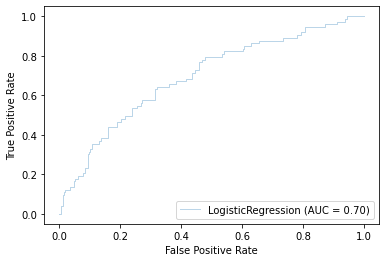

In [32]:
logistic = LogisticRegression()
logistic.fit(no_data_X_tr,no_labels_y_tr['Label'])

fig, ax = plt.subplots()
plot_roc_curve(logistic, no_data_X_te, no_labels_y_te['Label'],
                         alpha=0.3, lw=1, ax=ax)
plt.show()

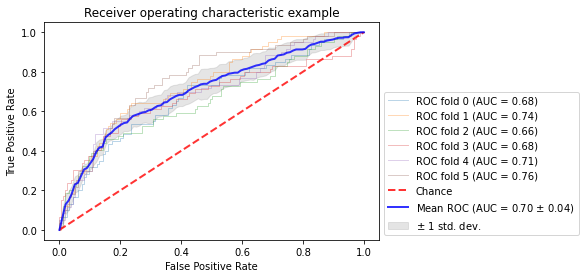

In [33]:
#roc_w_cross_val(no_data_X_tr.iloc[:,1:-5], no_labels_y_tr, LogisticRegression())

roc_w_cross_val(no_data_X_tr, no_labels_y_tr, LogisticRegression()) #AUC 62

#roc_w_cross_val(no_data_X_tr[c5], no_labels_y_tr, LogisticRegression())


### SVM

In [36]:
from sklearn.svm import SVC

#Create a svm Classifier
clf = SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(no_data_X_tr, no_labels_y_tr['Label'])

#Predict the response for test dataset
y_pred = clf.predict(no_data_X_te)

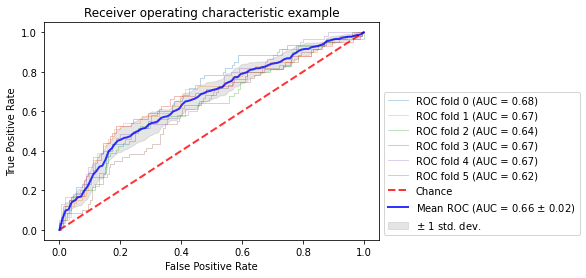

In [37]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, SVC(kernel='linear'))

### Linear Discriminant Analysis

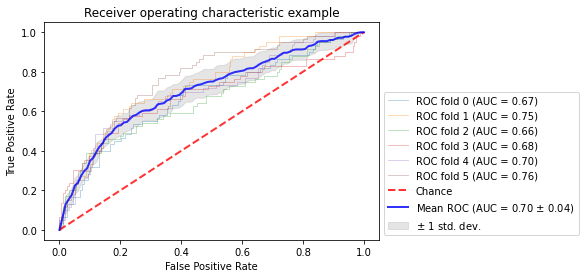

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf = LDA()
clf.fit(no_data_X_tr, no_labels_y_tr['Label'])
LDA(n_components=None, priors=None, shrinkage=None, solver='svd',
  store_covariance=False, tol=0.0001)


roc_w_cross_val(no_data_X_tr, no_labels_y_tr, LDA())

### k Nearest Neighbour

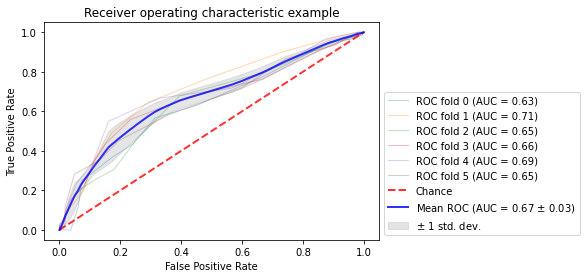

In [49]:
from sklearn.neighbors import KNeighborsClassifier

roc_w_cross_val(no_data_X_tr, no_labels_y_tr, KNeighborsClassifier(n_neighbors=16))

### Gaussian Naive Bayes

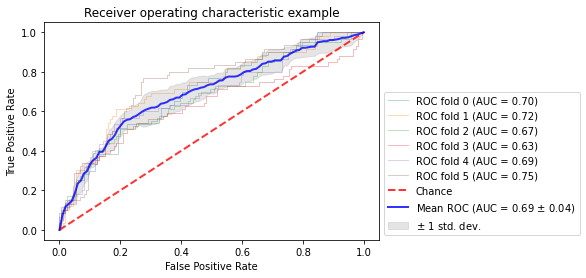

In [50]:
from sklearn.naive_bayes import GaussianNB

roc_w_cross_val(no_data_X_tr, no_labels_y_tr, GaussianNB())

### Decision Tree

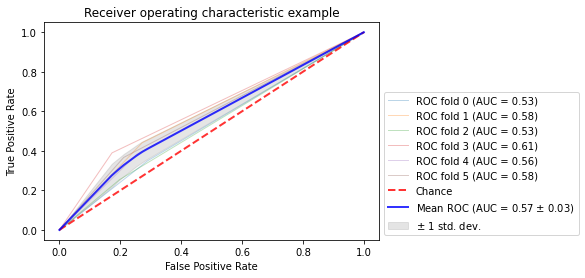

In [73]:
from sklearn.tree import DecisionTreeClassifier


roc_w_cross_val(no_data_X_tr, no_labels_y_tr, DecisionTreeClassifier(random_state=0))

### RandomForest

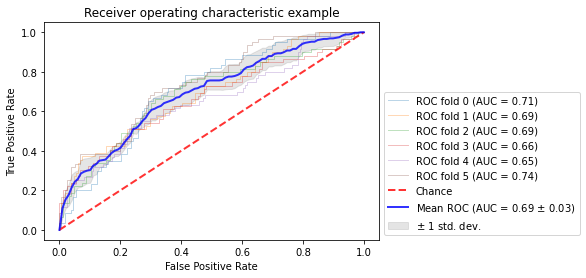

In [78]:
from sklearn.ensemble import RandomForestClassifier


roc_w_cross_val(no_data_X_tr, no_labels_y_tr, RandomForestClassifier(max_depth=7, random_state=0))

### eXtreme Gradient Boosting

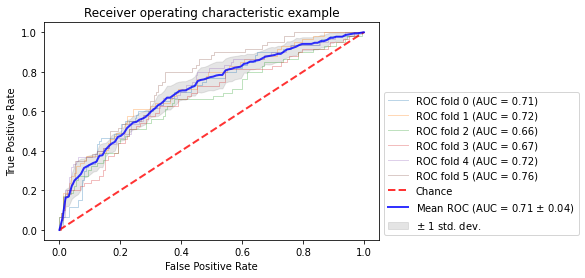

In [79]:
from sklearn.ensemble import GradientBoostingClassifier

roc_w_cross_val(no_data_X_tr, no_labels_y_tr, GradientBoostingClassifier(random_state=0))

3. Cross validation

1.Compare the success of different classifiers, very carefully performing afair model comparison (i.e. relying on validation scores using leave-n-subjects-out cross-validation).


4. Model Comparison


4.Compare classification success on segmented and non-segmented coughrecordings (all pre-processing will be done by the lab)
5.Tune the model hyperparameters appropriately

3.Assess the importance of different features to the classification result by analyzing the weights of the classifier or SHAP values.

5. Deep learning -> autoencoder
4.(Bonus) Try using Deep Learning methods to perform cough classificationdirectly on the raw audio signals

5. Explainability